## 1. Run with a fixed bound `N = 5`

In [1]:
import gurobipy as gp
from stlts import benchmarks

milp = gp.Model()

benchmark_name = 'rnc1'
bound = 5

prob = benchmarks.get_benchmark(milp, benchmark_name, N=bound, delta=0.1)

prob.search_satisfaction()

if prob.has_solution:
    print(prob.get_trace_result(interpolation=False))
else:
    print(f'No trace found with bound {bound}')

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2450049
Academic license 2450049 - for non-commercial use only - registered to so___@nii.ac.jp
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2450049 - for non-commercial use only - registered to so___@nii.ac.jp
Optimize a model with 308 rows, 861 columns and 1298 nonzeros
Model fingerprint: 0x6bd6a6fe
Model has 975 general constraints
Variable types: 284 continuous, 577 integer (577 binary)
Coefficient statistics:
  Matrix range     [5e-03, 5e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e-04, 1e+02]
  GenCon rhs range [1e-04, 9e+00]
  GenCon coe range [5e-01, 1e+00]
Presolve added 1073 rows and 0 columns
Presolve removed 0 rows and 142 columns
Pre

## 2. Increment the bound until a satisfying solution is found

In [2]:
import dataclasses

@dataclasses.dataclass
class Config:
    benchmark: str = 'rnc2'
    max_bound: int = 10
    optimize: bool = False
    stop_after_success: bool = True
    delta: float = 0.01

MILP_PARAMS = dict(
    MIPFocus=1,
    IntFeasTol=1e-7,
    FeasibilityTol=1e-7,
    MIPGap=1e-1,
    TimeLimit=20.0,
)

cfg = Config()

In [3]:
import contextlib
import io

import gurobipy as gp
import numpy as np

from stlts import benchmarks

first_satisfied_n = -1
runtimes = []
objective = []
runtime_to_synth: float = 0

with contextlib.redirect_stdout(io.StringIO()):  # suppress gurobi output
    for bound in range(1, cfg.max_bound + 1):
        milp = gp.Model()
        for k, v in MILP_PARAMS.items():
            milp.setParam(k, v)

        try:
            prob = benchmarks.get_benchmark(
                milp,
                name=cfg.benchmark,
                N=bound,
                optimize=cfg.optimize,
                delta=cfg.delta,
            )

            prob.search_satisfaction()
        except Exception as e:
            # print(f'Exception at bound {bound}')
            continue

        runtimes.append(milp.Runtime)
        objective.append(milp.ObjVal if prob.has_solution else np.nan)

        if prob.has_solution:
            if first_satisfied_n == -1:
                first_satisfied_n = bound
                runtime_to_synth = sum(runtimes)

            if cfg.stop_after_success:
                break

runtime_total = sum(runtimes)
print(f'total runtime: {runtime_total} seconds')
result = dict(
    runtime_total=runtime_total,
    first_satisfied_n=first_satisfied_n,
    runtime_to_synth=runtime_to_synth,
    runtimes=runtimes,
    objective=objective,
)

summary: dict = dict(params=cfg, result=result)
print(summary)

total runtime: 0.4041860103607178 seconds
{'params': Config(benchmark='rnc2', max_bound=10, optimize=False, stop_after_success=True, delta=0.01), 'result': {'runtime_total': 0.4041860103607178, 'first_satisfied_n': 4, 'runtime_to_synth': 0.4041860103607178, 'runtimes': [0.004884958267211914, 0.00978708267211914, 0.1605839729309082, 0.22892999649047852], 'objective': [nan, nan, nan, 0.0]}}


       t          x1         v1        a1          x2         v2       a2
0   0.00   45.000000   2.000000  0.000000    0.000000  12.284133 -1.50234
1   6.33   57.660000   2.000000  1.301291   47.660000   2.774319  1.00000
2   8.90   67.097450   5.344319  3.000000   58.092450   5.344319  1.01000
3   9.90   73.941769   8.344319  0.802970   63.941769   6.354319  1.00000
4  20.00  199.174892  16.454319  0.802970  179.125392  16.454319  1.00000


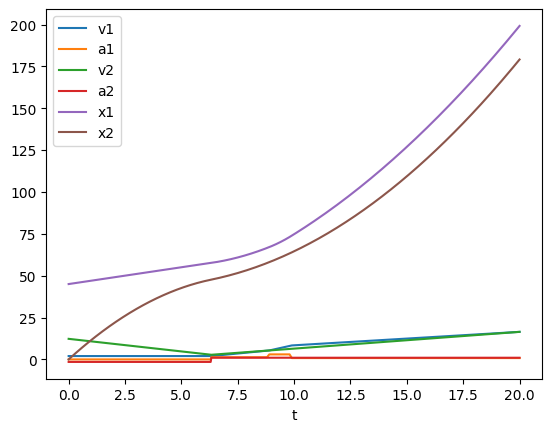

In [4]:
import matplotlib.pyplot as plt

if prob.has_solution:
    trace_raw = prob.get_trace_result(interpolation=False).df
    trace_continuous = prob.get_trace_result(interpolation=True).df
    print(trace_raw)
    trace_continuous.plot(x='t')